In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [5]:
#Loading the dataset
df = pd.read_csv('/content/credit_card_fraud_dataset.csv')
df.head()

,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688.0,refund,San Antonio,0.0
1,2,2024-03-19 13:20:35.462824,2659.71,109.0,refund,Dallas,0.0
2,3,2024-01-08 10:08:35.462834,784.00,394.0,purchase,New York,0.0
3,4,2024-04-13 23:50:35.462850,3514.40,944.0,purchase,Philadelphia,0.0
4,5,2024-07-12 18:51:35.462858,369.07,475.0,purchase,Phoenix,0.0


In [6]:
df.describe()

,TransactionID,Amount,MerchantID,IsFraud
count,65540.000000,65539.000000,65539.000000,65539.000000
mean,32770.500000,2492.341902,502.535971,0.009979
std,18919.912658,1444.803668,288.767632,0.099395
min,1.000000,1.070000,1.000000,0.000000
25%,16385.750000,1239.955000,254.000000,0.000000
50%,32770.500000,2485.510000,504.000000,0.000000
75%,49155.250000,3744.050000,753.000000,0.000000
max,65540.000000,4999.770000,1000.000000,1.000000


In [8]:
# Check class distribution
df['IsFraud'].value_counts(normalize=True)

,proportion
IsFraud,
0.0,0.990021
1.0,0.009979


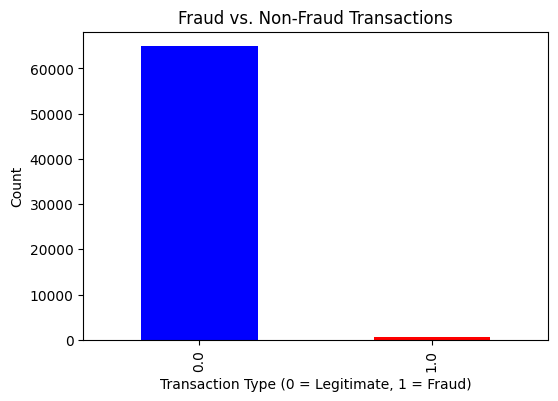

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['IsFraud'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title("Fraud vs. Non-Fraud Transactions")
plt.xlabel("Transaction Type (0 = Legitimate, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

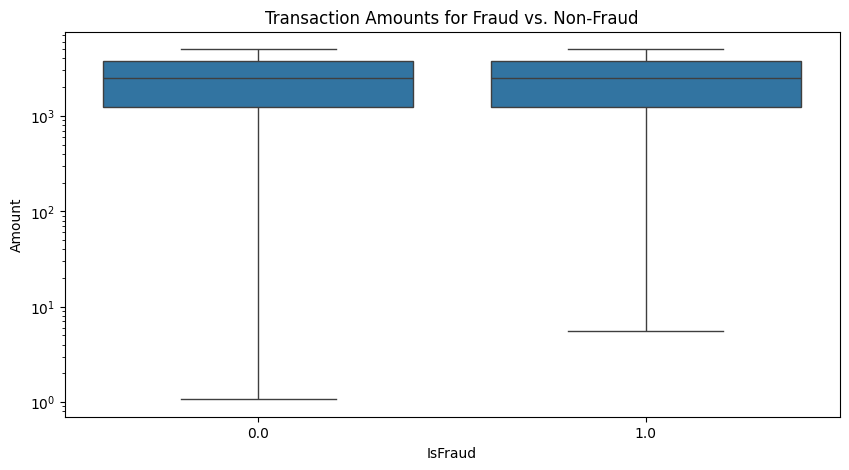

In [10]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.boxplot(x='IsFraud', y='Amount', data=df)
plt.yscale('log')  # Log scale to handle large amounts
plt.title("Transaction Amounts for Fraud vs. Non-Fraud")
plt.show()


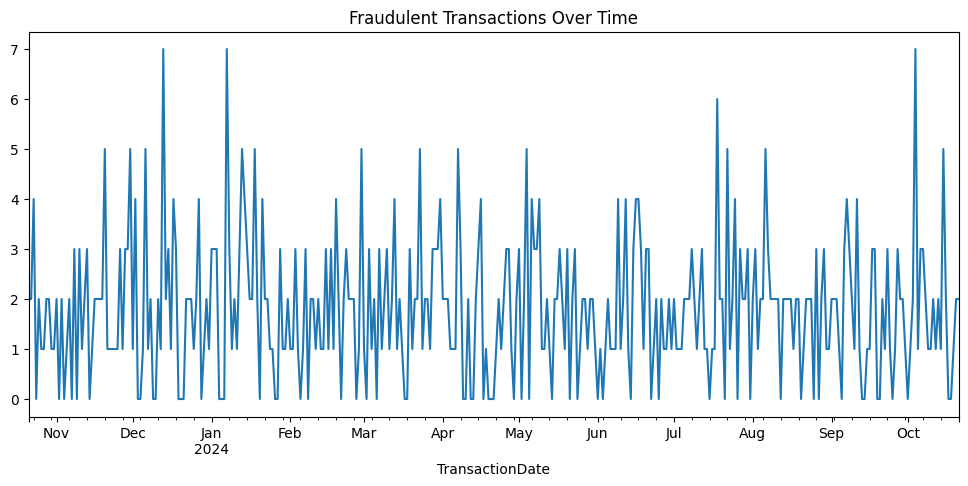

In [12]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')  # Convert to datetime, handle errors
df.dropna(subset=['TransactionDate'], inplace=True) #Drop rows with invalid dates
df.set_index('TransactionDate', inplace=True)

plt.figure(figsize=(12,5))
df.resample('D').sum()['IsFraud'].plot()
plt.title("Fraudulent Transactions Over Time")
plt.show()

In [13]:
df = pd.get_dummies(df, columns=['TransactionType', 'Location', 'MerchantID'], drop_first=True)


In [14]:
df.drop(columns=['TransactionID'], inplace=True)


In [15]:
df.fillna(df.median(), inplace=True)


## **🤖 Step 4: Train-Test Split & Apply SMOTE**

In [16]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Features & Target
X = df.drop(columns=['IsFraud'])
y = df['IsFraud']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


[[12901    76]
 [  130     1]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     12977
         1.0       0.01      0.01      0.01       131

    accuracy                           0.98     13108
   macro avg       0.50      0.50      0.50     13108
weighted avg       0.98      0.98      0.98     13108

AUC-ROC Score: 0.5012038327351915


In [19]:
from xgboost import XGBClassifier

# Compute scale_pos_weight
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:41:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[[3986 8991]
 [  47   84]]
              precision    recall  f1-score   support

         0.0       0.99      0.31      0.47     12977
         1.0       0.01      0.64      0.02       131

    accuracy                           0.31     13108
   macro avg       0.50      0.47      0.24     13108
weighted avg       0.98      0.31      0.46     13108

AUC-ROC Score: 0.46705680690499396


In [20]:
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

# Split the dataset
X = df.drop(columns=['IsFraud'])
y = df['IsFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE + Edited Nearest Neighbors (SMOTEENN)
smote_enn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

# Check new class distribution
print(pd.Series(y_train_resampled).value_counts(normalize=True))


IsFraud
1.0    0.736841
0.0    0.263159
Name: proportion, dtype: float64


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Assign weights (higher for fraud cases)
rf = RandomForestClassifier(class_weight="balanced", random_state=42)

# Train the model
rf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rf = rf.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_rf))
print("AUC-ROC Score:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     12977
         1.0       0.01      0.02      0.01       131

    accuracy                           0.98     13108
   macro avg       0.50      0.50      0.50     13108
weighted avg       0.98      0.98      0.98     13108

AUC-ROC Score: 0.5067962284417469


In [22]:
from xgboost import XGBClassifier

# Compute scale_pos_weight (ratio of majority to minority class)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="logloss", use_label_encoder=False, random_state=42)
xgb.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1]))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:21:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.99      0.30      0.45     12977
         1.0       0.01      0.71      0.02       131

    accuracy                           0.30     13108
   macro avg       0.50      0.50      0.24     13108
weighted avg       0.98      0.30      0.45     13108

AUC-ROC Score: 0.5115877356709198


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'class_weight': ['balanced']
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("Best parameters:", grid_search_rf.best_params_)


Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
